In [1]:
import os
import re
import gc
from functools import reduce, partial

import numpy as np
import nltk
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from pyspark.sql import SparkSession
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import roc_auc_score, classification_report, make_scorer

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/vagrant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def read_files(dir_path, label):
    raw = []
    paths = os.listdir(dir_path)
    num_paths = len(paths)
    for i in tqdm(range(num_paths)):
        with open(os.path.join(dir_path, paths[i]), 'r') as file:
            raw.append(file.read())
    
    return pd.DataFrame(list(zip(raw, [label] * len(raw))), columns=['text', 'label'])

In [4]:
pos_train_df = read_files('./aclImdb/train/pos', 1)
neg_train_df = read_files('./aclImdb/train/neg', 0)

pos_test_df = read_files('./aclImdb/test/pos', 1)
neg_test_df = read_files('./aclImdb/test/neg', 0)

train_df = pd.concat([pos_train_df, neg_train_df])
test_df = pd.concat([pos_test_df, neg_test_df])

train_df.index = pd.RangeIndex(25000)
test_df.index = pd.RangeIndex(25000)

100%|██████████| 12500/12500 [01:34<00:00, 131.71it/s]


# EDA

Let's try to get any useful information from the texts themselves, without any deep analysis:

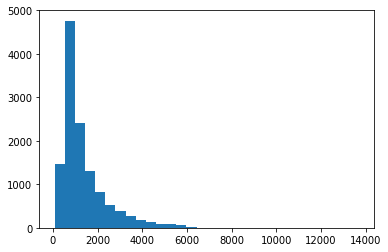

1347.16024 982.0


In [5]:
pos_lengths = pos_train_df['text'].apply(lambda text: len(text))
plt.hist(pos_lengths, bins=30)
plt.show()
print(pos_lengths.mean(), pos_lengths.median())

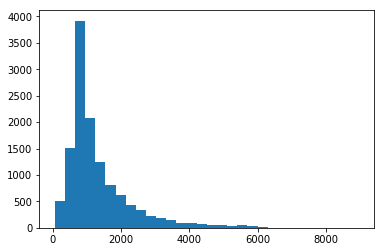

1302.97904 976.5


In [6]:
neg_lengths = neg_train_df['text'].apply(lambda text: len(text))
plt.hist(neg_lengths, bins=30)
plt.show()
print(neg_lengths.mean(), neg_lengths.median())

Negative reviewes tend to be just a bit shorter, but this is defintely not significant and won't help us.

(236.69568, 174.0)

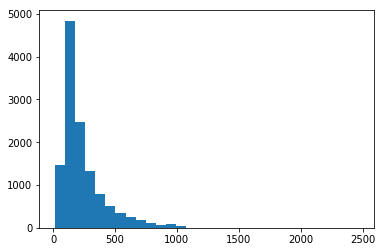

In [7]:
pos_words = pos_train_df['text'].apply(lambda text: len(text.split(' ')))
plt.hist(pos_words, bins=30)
pos_words.mean(), pos_words.median()

(230.85776, 174.0)

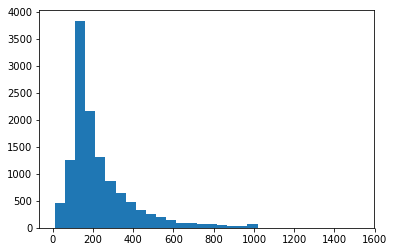

In [8]:
neg_words = neg_train_df['text'].apply(lambda text: len(text.split(' ')))
plt.hist(neg_words, bins=30)
neg_words.mean(), neg_words.median()

Even closer and more useless results in terms of length of review in words.

(4.660490237310027, 4.650445970479122)

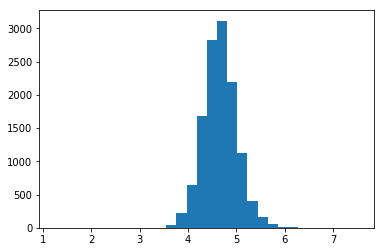

In [9]:
pos_word_lengths = pos_train_df['text'].apply(lambda text: sum([len(word) for word in text.split(' ')]) / len(text.split(' ')))
plt.hist(pos_word_lengths, bins=30)
pos_word_lengths.mean(), pos_word_lengths.median()

(4.627433057309819, 4.612451550387597)

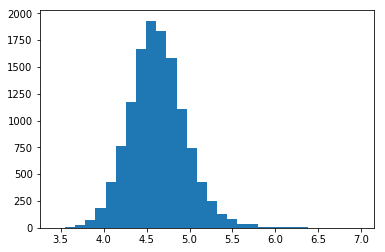

In [10]:
neg_word_lengths = neg_train_df['text'].apply(lambda text: sum([len(word) for word in text.split(' ')]) / len(text.split(' ')))
plt.hist(neg_word_lengths, bins=30)
neg_word_lengths.mean(), neg_word_lengths.median()

Average length of word is pretty much the same

# Tokenizing and stemming

In [11]:
ss = SparkSession.builder.master('local[*]').config('spark.driver.memory', '5G').config('spark.executor.memory', '5G').getOrCreate()

In [36]:
def tokenize_and_stem(series, stemmer, lemmatizer=False):
    tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
    rdd = ss.sparkContext.parallelize(series.values)
    tokenized_rdd = rdd.map(lambda text: tokenizer.tokenize(text))
    if not lemmatizer:
        stemed_rdd = tokenized_rdd.map(lambda words: [stemmer.stem(word) for word in words])
    else:
        stemed_rdd = tokenized_rdd.map(lambda words: [stemmer.lemmatize(word) for word in words])
    text_rdd = stemed_rdd.map(lambda words: '|'.join(words))
    return pd.Series(text_rdd.collect())


def evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    try:
        predictions = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        predictions = model.predict(X_test)
    return classification_report(y_test, predictions > 0.5), roc_auc_score(y_test, predictions)

def word_importances(bag_of_words, model, num=10):
    feature_names = bag_of_words.get_feature_names()
    importances = model.coef_[0]

    word_importances = pd.DataFrame({'word': feature_names, 'importance': importances})
    bad_words = word_importances.sort_values('importance').head(num)
    good_words = word_importances.sort_values('importance', ascending=False).head(num)
    return pd.DataFrame({
        'bad_word': bad_words['word'].values,
        'bad_importance': bad_words['importance'].values,
        'good_word': good_words['word'].values,
        'good_importance': good_words['importance'].values
    })

In [13]:
stemed_train = tokenize_and_stem(train_df['text'], WordNetLemmatizer(), lemmatizer=True)
stemed_test = tokenize_and_stem(test_df['text'], WordNetLemmatizer(), lemmatizer=True)

# Naive Bayes + Bag of words

In [42]:
bag_of_words = CountVectorizer(max_features=10000, max_df=0.3, stop_words='english')
bag_train = bag_of_words.fit_transform(train_df['text'])
bag_test = bag_of_words.transform(test_df['text'])

In [43]:
model = ComplementNB(alpha=100)
report, roc_auc = evaluate_model(bag_train, train_df['label'], bag_test, test_df['label'], model)
print(report)
print(roc_auc)

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     12500
           1       0.87      0.79      0.83     12500

   micro avg       0.84      0.84      0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

0.9116382272


### Let's try to use stemming

In [25]:
bag_of_words_stem = CountVectorizer(max_features=10000, max_df=0.3, stop_words='english')
bag_stemed_train = bag_of_words_stem.fit_transform(stemed_train)
bag_stemed_test = bag_of_words_stem.transform(stemed_test)

In [26]:
model = ComplementNB(alpha=100)
report, roc_auc = evaluate_model(bag_stemed_train, train_df['label'], bag_stemed_test, test_df['label'], model)
print(report)
print(roc_auc)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     12500
           1       0.87      0.79      0.83     12500

   micro avg       0.84      0.84      0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

0.9089294944


The results are not really different from the ones we achieved without stemming

# Logistic Regression + Bag of words

First of all, let's try the logistic regression without any parameters.

In [44]:
model = LogisticRegression()
report, roc_auc = evaluate_model(bag_train, train_df['label'], bag_test, test_df['label'], model)
print(report)
print(roc_auc)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.85      0.84      0.84     12500

   micro avg       0.85      0.85      0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

0.919399936


Let's use GridSearch to improve the result

In [45]:
params = {
    'max_iter': [50, 100, 150, 200],
    'solver': ['saga', 'sag', 'newton-cg', 'liblinear', 'lbfgs'],
    'C': [0.5, 0.75, 1],
    'penalty': ['l2']
}

grid = GridSearchCV(LogisticRegression(), params, scoring=make_scorer(roc_auc_score))
grid.fit(bag_train, train_df['label'])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iter

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_iter': [50, 100, 150, 200], 'solver': ['saga', 'sag', 'newton-cg', 'liblinear', 'lbfgs'], 'C': [0.5, 0.75, 1], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=0)

In [46]:
model = grid.best_estimator_
model

LogisticRegression(C=0.75, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
report, roc_auc = evaluate_model(bag_train, train_df['label'], bag_test, test_df['label'], model)
print(report)
print(roc_auc)

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12500
           1       0.87      0.88      0.87     12500

   micro avg       0.87      0.87      0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

0.944405312


Let's take a look at the word importnaces to see if the model is basing it's results on the same words as a real person would do:

In [48]:
word_importances(bag_of_words, model)

,bad_importance,bad_word,good_importance,good_word
0,-1.274459,worst,0.840432,excellent
1,-1.102335,waste,0.665097,perfect
2,-0.969169,awful,0.654195,wonderful
3,-0.827151,boring,0.641881,favorite
4,-0.722151,worse,0.604825,amazing
5,-0.710821,poorly,0.561751,loved
6,-0.693563,dull,0.539155,superb
7,-0.676435,poor,0.526806,today
8,-0.651050,horrible,0.508314,highly
9,-0.647481,disappointment,0.507958,brilliant


Wow, that's exactly what we expected it to be! 

Let's also try to add lemmitizing here:

In [49]:
report, roc_auc = evaluate_model(bag_stemed_train, train_df['label'], bag_stemed_test, test_df['label'], model)
print(report)
print(roc_auc)

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     12500
           1       0.87      0.88      0.87     12500

   micro avg       0.87      0.87      0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

0.9426402304


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Again, not very helpful

# SGDClassifier + Bag of words

In [50]:
model = SGDClassifier(loss='modified_huber', penalty='l1', max_iter=200, eta0=.00001, learning_rate='adaptive')
report, roc_auc = evaluate_model(bag_train, train_df['label'], bag_test, test_df['label'], model)
print(report)
print(roc_auc)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.87      0.88      0.88     12500

   micro avg       0.88      0.88      0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

0.9437308863999999


In [51]:
word_importances(bag_of_words, model)

,bad_importance,bad_word,good_importance,good_word
0,-0.450256,worst,0.288845,excellent
1,-0.426619,waste,0.248054,favorite
2,-0.358290,awful,0.242760,perfect
3,-0.308053,disappointment,0.232948,wonderful
4,-0.305412,boring,0.221839,amazing
5,-0.297672,poorly,0.220255,superb
6,-0.282433,dull,0.209129,loved
7,-0.270538,worse,0.198171,enjoyable
8,-0.264528,disappointing,0.196812,today
9,-0.252266,horrible,0.196013,perfectly


Looks like it is the best we can get from Bag of words. Let's try some other methods:

# TF-IDF

In [52]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', sublinear_tf=True, max_df=0.7)
tfidf_train = tfidf.fit_transform(stemed_train)
tfidf_test = tfidf.transform(stemed_test)

In [53]:
model = ComplementNB(alpha=2)
report, roc_auc = evaluate_model(tfidf_train, train_df['label'], tfidf_test, test_df['label'], model)
print(report)
print(roc_auc)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     12500
           1       0.87      0.80      0.83     12500

   micro avg       0.84      0.84      0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

0.9194040319999999


In [54]:
model = SGDClassifier(loss='modified_huber', penalty='l1', max_iter=200, eta0=.00001, learning_rate='adaptive')
report, roc_auc = evaluate_model(tfidf_train, train_df['label'], tfidf_test, test_df['label'], model)
print(report)
print(roc_auc)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.83     12500

   micro avg       0.84      0.84      0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

0.9174319872


In [55]:
word_importances(tfidf, model)

,bad_importance,bad_word,good_importance,good_word
0,-0.813811,bad,0.623438,great
1,-0.593837,worst,0.401352,best
2,-0.424598,waste,0.391234,love
3,-0.393516,awful,0.372001,excellent
4,-0.335350,terrible,0.320569,wonderful
5,-0.327765,boring,0.281778,performance
6,-0.317120,plot,0.278429,life
7,-0.299869,stupid,0.262683,favorite
8,-0.298736,worse,0.250405,perfect
9,-0.298032,minute,0.249714,loved


In [56]:
model = LogisticRegression(solver='newton-cg', penalty='l2', max_iter=100, C=2)
report, roc_auc = evaluate_model(tfidf_train, train_df['label'], tfidf_test, test_df['label'], model)
print(report)
print(roc_auc)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

   micro avg       0.88      0.88      0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

0.9510070144


In [57]:
word_importances(tfidf, model)

,bad_importance,bad_word,good_importance,good_word
0,-10.642100,worst,7.945864,great
1,-8.018004,waste,7.516254,excellent
2,-7.988801,awful,5.993586,perfect
3,-7.732067,bad,5.881730,best
4,-6.583371,boring,5.683254,wonderful
5,-6.193961,poor,5.547731,favorite
6,-5.893898,worse,4.906980,amazing
7,-5.851771,poorly,4.634467,loved
8,-5.558549,disappointment,4.560583,today
9,-5.376655,dull,4.381601,fun


TF-IDF manages to provide better results for Naive Bayes model and Logistic Regression, but gives worse results for SGDClassifier.